<h1 align="center">---- Data Science ----</h1>

----

**0) Packages**

In [ ]:
using Pkg
Pkg.add("LightGraphs")
Pkg.add("MatrixNetworks")

In [1]:
using LightGraphs
using MatrixNetworks
using VegaDatasets
using DataFrames
using SparseArrays
using LinearAlgebra
using Plots
using VegaLite

----

**1) Preparing Dataset**

In [2]:
# Getting datasets
airports = dataset("airports")
flights_airport = dataset("flights-airport")

airports_df = DataFrame(airports)
flights_airport_df = DataFrame(flights_airport)

Row,origin,destination,count
,String,String,Int64
1,ABE,ATL,853
2,ABE,BHM,1
3,ABE,CLE,805
4,ABE,CLT,465
5,ABE,CVG,247
6,ABE,DTW,997
7,ABE,JFK,3
8,ABE,LGA,9
9,ABE,ORD,1425


In [3]:
# Getting unique airports
all_airports = vcat(flights_airport_df[:, :origin], flights_airport_df[:, :destination])
unique_airports = unique(all_airports)

305-element Vector{String}:
 "ABE"
 "ABI"
 "ABQ"
 "ABY"
 "ACK"
 "ACT"
 "ACV"
 "ACY"
 "ADK"
 "ADQ"
 "AEX"
 "AGS"
 "AKN"
 ⋮
 "TYR"
 "TYS"
 "VLD"
 "VPS"
 "WRG"
 "WYS"
 "XNA"
 "YAK"
 "YKM"
 "YUM"
 "CYS"
 "OGD"

In [4]:
# creating an airports data frame that has a subset
# of airports that are only included in the routes dataset
subset_airports = map(i-> findfirst(airports_df[:, :iata].==unique_airports[i]), 1:length(unique_airports))
airports_df_subset = airports_df[subset_airports, :]

Row,iata,name,city,state,country,latitude,longitude
,String,String,String,String,String,Float64,Float64
1,ABE,Lehigh Valley International,Allentown,PA,USA,40.6524,-75.4404
2,ABI,Abilene Regional,Abilene,TX,USA,32.4113,-99.6819
3,ABQ,Albuquerque International,Albuquerque,NM,USA,35.0402,-106.609
4,ABY,Southwest Georgia Regional,Albany,GA,USA,31.5355,-84.1945
5,ACK,Nantucket Memorial,Nantucket,MA,USA,41.2531,-70.0602
6,ACT,Waco Regional,Waco,TX,USA,31.6113,-97.2305
7,ACV,Arcata,Arcata/Eureka,CA,USA,40.9781,-124.109
8,ACY,Atlantic City International,Atlantic City,NJ,USA,39.4576,-74.5772
9,ADK,Adak,Adak,AK,USA,51.878,-176.646


In [5]:
# building adjacency matrix
ei_ids = findfirst.(isequal.(flights_airport_df[!, :origin]), [unique_airports])
ej_ids = findfirst.(isequal.(flights_airport_df[!, :destination]), [unique_airports])
edge_weights = flights_airport_df[!, :count]

adjacense_matrix = sparse(ei_ids, ej_ids, 1, length(unique_airports), length(unique_airports))
adjacense_matrix = max.(adjacense_matrix, adjacense_matrix')

305×305 SparseMatrixCSC{Int64, Int64} with 5668 stored entries:
⠀⠀⣾⠀⠁⡂⡂⠄⡋⢚⢚⣊⢒⢀⠀⠀⠀⢒⠀⢸⡒⡍⠐⣒⠈⠠⡒⢚⢚⠀⠀⠀⠐⡰⠰⠖⠀⡒⠀⠀
⠚⠛⢾⠓⠲⡚⡖⠓⠖⢺⢻⢻⢺⡶⠂⠗⠒⠿⠖⣺⣿⠖⠒⠶⠶⡚⡟⠻⢿⠒⠰⠗⢞⢛⢺⡒⠲⠞⠒⠆
⠡⠠⣸⠢⠪⠂⢧⠰⠷⢺⢹⠸⢸⠰⠲⠢⠁⣻⠄⠸⠷⠇⠒⢿⠾⠀⡷⢻⠾⠇⠸⠷⠴⡸⢺⠸⠤⠇⠂⠁
⠈⠌⢼⠉⢉⡓⠁⠀⡉⢸⢹⣸⢘⡘⠀⠈⠂⢹⡋⢉⠻⡋⠈⢻⢉⢀⡋⢹⠉⠉⠉⠉⢋⢸⠼⠉⠐⠋⠀⠆
⣫⢈⣸⣁⣹⣃⣃⣈⣏⣹⣹⣹⣘⢍⡀⣚⠀⣼⡇⣘⣿⣯⢸⣻⣻⢈⡏⣿⣻⡍⢌⣋⣫⣨⣸⣝⢙⣋⣁⡄
⡺⢰⣿⣒⣓⡒⣓⣲⣗⣺⣺⣺⣛⢒⡒⣖⠒⣻⣂⣒⣻⣿⢚⣳⣺⢲⡗⣿⣲⡒⢒⣖⣚⣐⣲⢚⣐⣛⡒⡒
⠘⢐⢺⡶⢒⡒⣒⠰⡖⢜⢻⢘⢄⠑⠀⡒⠐⣛⣂⢒⣿⡖⢰⣚⣳⠰⣆⢿⢻⣃⣖⣓⡺⢾⢸⢺⢒⡚⠆⠦
⠀⠀⢬⠄⠸⡂⡀⠀⣠⢨⢸⢬⢠⠠⠄⠁⠤⢠⠀⢀⠳⡃⠀⣩⣨⠨⡗⢾⢺⠄⠄⡖⠑⠸⠹⠂⠀⠽⠀⠄
⢠⢀⣼⡄⣥⣠⣌⣀⣀⣤⣼⣠⣴⢠⠀⣃⢀⣴⡀⣼⣤⣢⣠⣤⣀⡀⣧⣼⣤⣄⣀⣀⣤⢠⣸⣤⣀⣤⣀⡀
⣀⣀⣸⣡⣀⡁⡏⢈⣉⢩⢨⢸⢨⢘⠀⢀⣀⣬⡄⣩⣻⣁⢉⣿⡉⠀⣧⣩⣊⡁⣄⣁⣋⢈⣩⣈⣀⣃⡀⡃
⡜⠬⢻⠟⠽⠇⡿⠢⡿⣿⣿⣾⢻⠿⠽⠢⠠⣻⠟⢺⣎⠝⢘⣿⡿⠺⣿⣿⣿⠇⠋⠿⢿⢻⢻⣿⠄⠿⠬⠇
⢰⢠⢸⡄⣼⣄⣦⣀⣶⣲⢾⣰⣰⢲⡄⣠⠀⣾⣧⣴⣶⣴⢠⡶⣶⣐⣗⣾⣶⣦⢤⣦⣶⢰⣸⣲⠠⣶⣆⡀
⠂⡀⣸⠣⠚⠃⠃⢐⡛⢚⢺⣚⢙⡚⡂⡚⠀⠸⠃⠈⣻⡋⢘⢻⢔⠑⡇⣾⣙⡃⠈⣫⢛⣹⢘⠘⠁⢓⠁⠁
⣸⢈⣿⡉⣽⣋⣏⣈⣯⣭⣽⣭⣬⣝⣹⣍⣉⣿⡍⣻⣿⣿⣹⣽⣩⣭⣵⣿⣿⣁⣍⣹⣹⣹⣹⣯⣈⣹⣁⡁
⠚⠐⢻⠓⠾⠇⡇⠀⡟⠾⢸⠺⠿⢲⠚⠖⠀⢿⠎⠸⠿⠟⠸⣿⠷⠸⠟⢻⠾⠃⠓⠻⠟⢺⢼⠓⠚⡗⡀⠂
⠀⠀⢴⠆⢶⡆⡇⠀⡦⢱⢸⢴⢼⢹⢠⠥⠀⢸⠄⢹⣯⡄⠠⣷⡦⣠⣇⣹⣽⡀⠀⡠⢰⢸⢹⡢⠀⢎⠋⠄
⢐⡠⣾⢑⣐⡣⣋⣐⡋⣺⢚⢸⣺⣎⣑⡀⠀⣛⡋⢘⣿⣓⢘⣛⣟⣰⣗⣺⣻⣁⣐⣒⢰⣲⣰⣚⠀⣓⡀⠀
⢰⠆⢺⠲⣚⡒⡖⠃⣖⢾⣸⢚⣲⣒⠳⠂⠒⣾⡃⢺⣿⣶⢲⣺⣒⠐⡷⣾⢶⠓⠳⡲⣰⢺⣺⣾⠂⣲⠗⠓
⢠⠠⣸⠆⠤⠇⡴⠀⡷⢰⣴⢸⣸⠰⣄⡄⠀⣼⠤⢸⣤⡅⢠⣦⢥⢀⣆⣸⢾⠤⡠⢄⢤⢠⢨⣠⠠⠆⠁⡀
⠀⠀⠸⠄⠌⠀⠠⠄⠁⠼⢸⠨⠨⡅⠀⠄⠀⠸⠤⠨⠦⠇⠈⠹⠅⠀⠅⠸⠠⠈⠋⠄⠀⠈⢽⠁⠁⠠⠀⠀

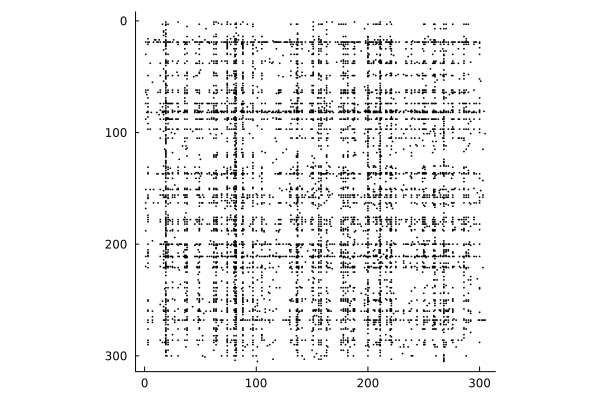

In [6]:
spy(adjacense_matrix)

In [7]:
issymmetric(adjacense_matrix)

true

----

**2) Creating Graphs**

In [9]:
# Example of how to use Simple Graph
# (this cell is not necessary to be executed)
light_graph = SimpleGraph(adjacense_matrix)

graph = SimpleGraph(10)
add_edge!(graph, 7, 5)
add_edge!(graph, 3, 5)
add_edge!(graph, 5, 2)

s_components = scomponents(adjacense_matrix)

MatrixNetworks.Strong_components_output([1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [305], 1, MatrixNetwork{Int64}(305, [1, 13, 15, 56, 57, 60, 61, 67, 70, 71  …  5619, 5626, 5628, 5629, 5656, 5658, 5659, 5665, 5667, 5669], [19, 30, 62, 64, 74, 88, 151, 163, 168, 188  …  115, 143, 156, 158, 221, 268, 81, 268, 101, 268], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

----

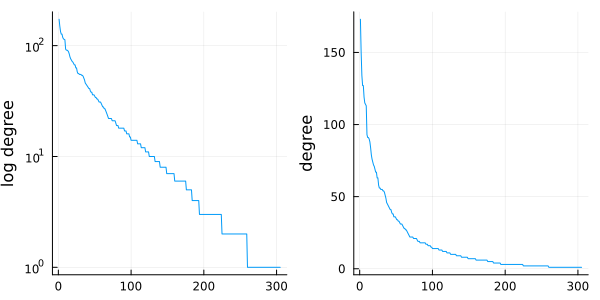

In [8]:
# Building Plot
degress = sum(adjacense_matrix, dims=2)[:]
p1 = plot(sort(degress, rev=true), ylabel="log degree", legend=false, yaxis=:log)
p2 = plot(sort(degress, rev=true), ylabel="degree", legend=false)
plot(p1, p2, size=(600,300))